1. Ожирение --- https://www.euro.who.int/__data/assets/pdf_file/0015/243321/Russian-Federation-WHO-Country-Profile.pdf

2. Диабет --- https://www.who.int/diabetes/country-profiles/rus_en.pdf

In [25]:
import pandas as pd

In [26]:
def age2interval(pd_age_series):
    return pd_age_series.apply(lambda x: pd.Interval(left=int(x[:x.find('-')]), right=int(x[x.find('-') + 1:]), closed='both'))

In [27]:
nw1000m = pd.read_csv('data/nw1000m.csv')
nw1000m['age'] = age2interval(nw1000m['age'])
nw1000m['female_proba'] = nw1000m['value'] / (nw1000m['value']  + 1000)

In [28]:
from scipy import stats

age_proba = pd.read_csv('data/age_proba.csv')
age_variable = stats.rv_discrete(name='russianage', values=(age_proba['age'], age_proba['proba']))


In [29]:
age_sex_risk = pd.read_csv('data/age_sex_risk.csv')
age_sex_risk['age'] = age2interval(age_sex_risk['age'])

In [30]:
def cad_age(age):
    return 1/30

def cad_sex(sex): # модификатор от 0 до inf
    return 1


def cad_age_sex(age, sex):
    risk_age = age_sex_risk[age_sex_risk['age'].apply(lambda x: age in x)]
    return float(risk_age[risk_age['sex'] == sex]['risk'])

def cad_smoke(smoke):
    return 1.3 if smoke == 1 else 1

def cad_overweight(sex):
    return 
        
    

In [122]:
from scipy.stats import bernoulli

smoking = pd.read_csv('data/smoking.csv')
smoking['age'] = age2interval(smoking['age'])

def smoke_proba_age_sex(age, sex):
    """
    age: возраст
    sex: 1 - муж., 0 - жен
    
    return: 1 - курит, 0 - не курит (с учетом пола и возраста)
    """
    smoking_age = smoking[smoking['age'].apply(lambda x: age in x)]
    
    smoke_proba = float(smoking_age[smoking_age['sex'] == sex]['smoke'])
    
    rv = stats.bernoulli(smoke_proba)
    return rv.rvs(), smoke_proba

class People:
    risks = dict()
    
    def gen_age(self):
        age = lambda: q if (q := age_variable.rvs()) >= 20 else age()
        self.age = age()
        
        # self.risks['age'] = cad_age(self.age)
        # self.risk = self.risks['age']
        
    
    def gen_sex(self):
        fem_prob = float(nw1000m[nw1000m['age'].apply(lambda x: self.age in x)]['female_proba'])
        rv = bernoulli(1 - fem_prob)
        self.sex = rv.rvs()
        
        # self.risks['sex'] = cad_sex(self.sex)
        
        # self.risk = self.risk*self.risks['sex']
        self.risks['age_sex'] = cad_age_sex(self.age, self.sex)
        self.risk = cad_age_sex(self.age, self.sex)
        
        
    def gen_smoke(self):

        self.smoke, smoke_proba = smoke_proba_age_sex(self.age, self.sex)
        self.risks['smoke'] = cad_smoke(self.smoke)
        
        self.risk *= (1.3  * smoke_proba + (1 - smoke_proba)) if self.smoke == 1 else 1
        
    def gen_overweight(self):
        overweight_proba = 0.247 if self.sex == 0 else 0.179
        rv = bernoulli(overweight_proba)
        self.overweight = rv.rvs()
        self.risk *= (2 * overweight_proba + (1 - overweight_proba))  if self.overweight == 1 else 1
    
   # def gen_diabetes(self):
        
    #    diabetes_proba = 
    #    rv = bernoulli(diabetes_proba)
    #    self.diabetes = rv.rvs()
        
     #   self.risk *= 4 if self.diabetes == 1 else 1
    
    def gen_snps(self):
        ...
        
        
    def calc_target(self):
        rv = bernoulli(self.risk)
        self.target =  rv.rvs()
        
    def to_series(self):
        return pd.Series(
                          { 'age': self.age
                          , 'sex': self.sex
                          , 'smoke': self.smoke
                          , 'overweight': self.overweight
                          # , 'diabetes': self.diabetes
                          , 'overall_risk': self.risk
                          , 'disease (target)': self.target
                          })
        
    def gen_all(self):
        self.gen_age()
        self.gen_sex()
        self.gen_smoke()
        self.gen_overweight()
        # self.gen_diabetes()
        self.gen_snps()
        self.calc_target()
        
        

In [123]:
def make_sample(number):
    peoples = []
    for _ in range(number):
        p = People()
        p.gen_all()
        peoples.append(p.to_series())
    return pd.DataFrame(peoples)

In [124]:
%%time
df = make_sample(5000)

CPU times: user 36.2 s, sys: 15.9 ms, total: 36.2 s
Wall time: 36.1 s


In [125]:
df['overall_risk']

0       0.007229
1       0.006000
2       0.056000
3       0.006000
4       0.097000
          ...   
4995    0.056000
4996    0.188000
4997    0.074277
4998    0.088182
4999    0.007229
Name: overall_risk, Length: 5000, dtype: float64

In [126]:
data = df.drop(['overall_risk'], axis=1)

In [127]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.linear_model import LogisticRegression

In [128]:
X_train, X_test, y_train, y_test = train_test_split(data.drop('disease (target)', axis=1), data['disease (target)'], test_size=0.2, random_state=42)

In [129]:
md = CatBoostClassifier()

In [130]:
md.fit(X_train, y_train)

Learning rate set to 0.018621
0:	learn: 0.6672886	total: 2ms	remaining: 2s
1:	learn: 0.6450431	total: 3.94ms	remaining: 1.97s
2:	learn: 0.6229667	total: 5.99ms	remaining: 1.99s
3:	learn: 0.6009560	total: 7.82ms	remaining: 1.95s
4:	learn: 0.5810912	total: 9.82ms	remaining: 1.95s
5:	learn: 0.5614472	total: 11.8ms	remaining: 1.95s
6:	learn: 0.5467131	total: 13.8ms	remaining: 1.96s
7:	learn: 0.5302380	total: 15.5ms	remaining: 1.92s
8:	learn: 0.5123964	total: 17.3ms	remaining: 1.91s
9:	learn: 0.4997706	total: 19ms	remaining: 1.89s
10:	learn: 0.4855870	total: 21.2ms	remaining: 1.9s
11:	learn: 0.4716947	total: 23.1ms	remaining: 1.9s
12:	learn: 0.4585704	total: 24.7ms	remaining: 1.88s
13:	learn: 0.4478854	total: 26.3ms	remaining: 1.85s
14:	learn: 0.4361983	total: 27.8ms	remaining: 1.83s
15:	learn: 0.4253942	total: 29.1ms	remaining: 1.79s
16:	learn: 0.4152764	total: 30.4ms	remaining: 1.76s
17:	learn: 0.4059972	total: 32ms	remaining: 1.75s
18:	learn: 0.3966509	total: 34.7ms	remaining: 1.79s
19:	

In [131]:
roc_auc_score(y_test, md.predict_proba(X_test).T[1])

0.7535470545977012

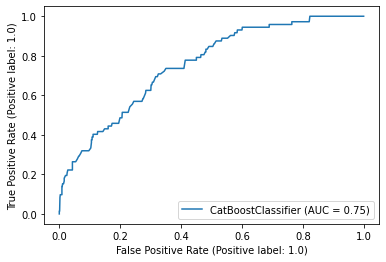

In [132]:
plot_roc_curve(md, X_test, y_test)

In [133]:
mdlr = LogisticRegression()

In [134]:
mdlr.fit(X_train, y_train)

LogisticRegression()

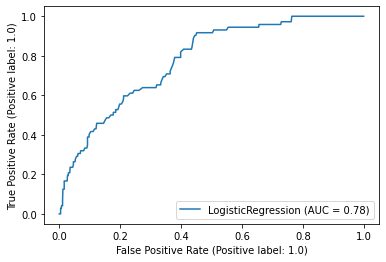

In [135]:
plot_roc_curve(mdlr, X_test, y_test)

<AxesSubplot:xlabel='overall_risk', ylabel='Density'>

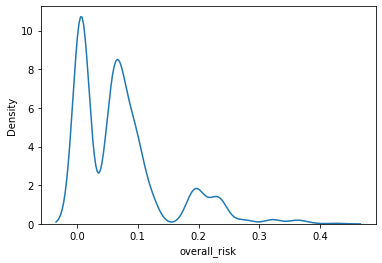

In [136]:
import seaborn as sns

sns.kdeplot(df['overall_risk'])

<AxesSubplot:xlabel='overall_risk', ylabel='Density'>

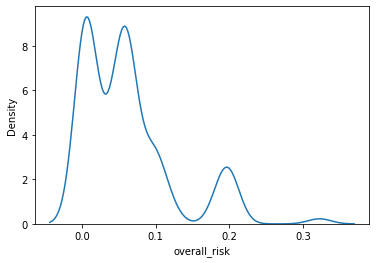

In [63]:
import seaborn as sns

sns.kdeplot(df['overall_risk'])

<AxesSubplot:xlabel='overall_risk', ylabel='Density'>

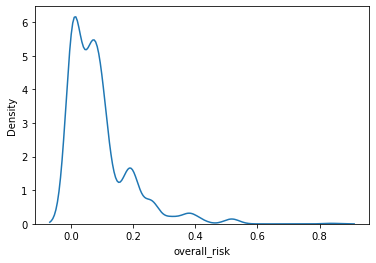

In [56]:
import seaborn as sns

sns.kdeplot(df['overall_risk'])

In [18]:
df['disease (target)'].sum()

84.0